In [90]:
import copy
import math
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import pandas as pd
import time

from ast import literal_eval
from matplotlib.ticker import FuncFormatter
from IPython.display import display, clear_output

In [4]:
# pull in our gquery module and import the config
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/anony'
#os.environ['GUFI_DEBUG']='TRUE'
import gquery as gq

config=gq.query_gconfig()
nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
print(f"Using {nthreads} threads on {indexroot}")

Using 224 threads on /mnt/nvme1n1/jbent/anony


In [57]:
def run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose=False):
    cmd = 'gufi_query'
    command = [
        cmd,
        "-I", create_int,
        "-S", insert_int,
        "-K", create_agg,
        "-J", insert_agg,
        "-G", select_agg,
        "-n", nthreads,
        indexroot
    ]
    if Verbose:
        print(f"Running {cmd} on {indexroot} with {nthreads} threads using the following command:")
        print('\n\t'.join([line for line in command]))
    
    start_time = time.time()
    completed_process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()
    
    if completed_process.returncode != 0:
        print(f"An error occurred:\n{completed_process.stderr.decode('utf-8')}")
        return None
    else:
        output = completed_process.stdout.decode('utf-8')
        if Verbose:
            print(f"Output:\n{output}")
            print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")
        return output

In [49]:
# a function to pull the predefined file size bins using the native gufi function
def get_predefined_bins(indexroot,Verbose=True):
    cmd = 'gufi_query'
    tab = 'vrsummary'
    itab = 'intermediate'
    atab = 'aggregate'
    fields = ('totltk', 'totmtk', 'totltm', 'totmtm', 'totmtg', 'totmtt')
    
    # int and agg use identical syntax for create so use helper function
    def create_table_str(table):
        create_str = ','.join([f"{field} INT64" for field in fields])
        return f"CREATE TABLE {table}({create_str});"
    
    # int and agg use identical syntax for insert so use helper function
    def insert_str(source,dest):
        select_str = ','.join([f"{field}" for field in fields])
        return f"INSERT INTO {dest} SELECT {select_str} from {source};"
    
    # create the string to select all the sums from the agg table
    agg_sum_str = ','.join([f"sum({field})" for field in fields])
    agg_select_str = f"SELECT {agg_sum_str} from {atab};"

    # now that we have all the strings constructed, we can run the command
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = nthreads,
        create_int = create_table_str(itab),
        insert_int = insert_str(tab,itab),
        create_agg = create_table_str(atab),
        insert_agg = insert_str(itab,atab),
        select_agg = agg_select_str,
        Verbose    = Verbose
    )
    
    # convert the output into a dict corresponding to our fields
    out_dict = dict(zip(fields, map(int, output.split())))
    return out_dict

In [50]:
output = get_predefined_bins(indexroot,Verbose=True)
print(output)

Running gufi_query on /mnt/nvme1n1/jbent/anony with 224 threads using the following command:
gufi_query
	-n
	224
	-I
	CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);
	-S
	INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt from vrsummary;
	-K
	CREATE TABLE aggregate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);
	-J
	INSERT INTO aggregate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt from intermediate;
	-G
	SELECT sum(totltk),sum(totmtk),sum(totltm),sum(totmtm),sum(totmtg),sum(totmtt) from aggregate;
	/mnt/nvme1n1/jbent/anony
Output:
667281289084516114578275511790534413227

Elapsed time: 2.01 minutes
{'totltk': 66728128, 'totmtk': 90845161, 'totltm': 145782755, 'totmtm': 11790534, 'totmtg': 41322, 'totmtt': 7}


In [59]:
def fill_bins(all_bins, indexroot, Verbose=True):
    if indexroot in all_bins:
        print(f"Cowardly refusing to overwrite an existing entry for {indexroot}")
    else:
        bins = get_predefined_bins(indexroot, Verbose)
        all_bins[indexroot] = bins

In [65]:
if 'all_bins' not in locals():
    all_bins = {}

indexroots = ["/mnt/nvme3n1/jbent/jbent_home/", 
              "/mnt/nvme1n1/jbent/scr4/", 
              "/mnt/nvme1n1/jbent/yellprojs/", 
              "/mnt/nvme1n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme1n1/jbent/anony"]

for ir in indexroots:
    fill_bins(all_bins,ir,Verbose=True)

Running gufi_query on /mnt/nvme3n1/jbent/jbent_home/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);
	-S
	INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt from vrsummary;
	-K
	CREATE TABLE aggregate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);
	-J
	INSERT INTO aggregate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt from intermediate;
	-G
	SELECT sum(totltk),sum(totmtk),sum(totltm),sum(totmtm),sum(totmtg),sum(totmtt) from aggregate;
	-n
	224
	/mnt/nvme3n1/jbent/jbent_home/
['gufi_query', '-I', 'CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);', '-S', 'INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt from vrsummary;', '-K', 'CREATE TABLE aggregate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64);',

In [56]:
# the predefined bins don't have zero-byte files in them. So let's compute that separately. Bummer we have to
# do another pass. Oh well.
def count_empty_files(indexroot, Verbose=True):
    zfiles = run_gufi_query(
        indexroot  = indexroot,
        nthreads   = nthreads,
        create_int = "CREATE TABLE intermediate(quantity INT64);",
        insert_int = "INSERT INTO intermediate SELECT count(*) FROM vrpentries where size=0;",
        create_agg = "CREATE TABLE aggregate(quantity INT64);",
        insert_agg = "INSERT INTO aggregate SELECT count(*) FROM intermediate;",
        select_agg = "SELECT sum(quantity) FROM aggregate;",
        Verbose    = Verbose
    )
    return int(zfiles)

In [67]:
def add_empty_files(all_bins, indexroot, Verbose=True):
    zkey = 'totzero'
    if zkey not in all_bins[indexroot]:
        zfiles = count_empty_files(indexroot, Verbose)
        all_bins[indexroot][zkey] = zfiles
    else:
        print(f"Cowardly refusing to overwrite an existing {zkey} entry for {indexroot}")

for ir in indexroots:
    add_empty_files(all_bins,ir,Verbose=True)

Cowardly refusing to overwrite an existing totzero entry for /mnt/nvme3n1/jbent/jbent_home/
Running gufi_query on /mnt/nvme1n1/jbent/scr4/ with 224 threads using the following command:
gufi_query
	-I
	CREATE TABLE intermediate(quantity INT64);
	-S
	INSERT INTO intermediate SELECT count(*) FROM vrpentries where size=0;
	-K
	CREATE TABLE aggregate(quantity INT64);
	-J
	INSERT INTO aggregate SELECT count(*) FROM intermediate;
	-G
	SELECT sum(quantity) FROM aggregate;
	-n
	224
	/mnt/nvme1n1/jbent/scr4/
['gufi_query', '-I', 'CREATE TABLE intermediate(quantity INT64);', '-S', 'INSERT INTO intermediate SELECT count(*) FROM vrpentries where size=0;', '-K', 'CREATE TABLE aggregate(quantity INT64);', '-J', 'INSERT INTO aggregate SELECT count(*) FROM intermediate;', '-G', 'SELECT sum(quantity) FROM aggregate;', '-n', '224', '/mnt/nvme1n1/jbent/scr4/']
Output:
5068374

Elapsed time: 1.44 minutes
Running gufi_query on /mnt/nvme1n1/jbent/yellprojs/ with 224 threads using the following command:
gufi_

In [69]:
#del(all_bins['/mnt/nvme3n1/jbent/jbent_home/'])

In [114]:
def convert_to_dataframe(bins):
    ub = 'Upper_Bound'
    nf = 'Num_Files'
    infinity = '\u221E'
    data = { ub : [], nf : []}
    tot = bins['totltk'] + bins['totmtk']
    data[ub].append('[0]')
    data[nf].append(bins['totzero'])
    data[ub].append('(0, 1K]')
    data[nf].append(bins['totltk'] - bins['totzero'])
    data[ub].append('(1K, 1M]')
    data[nf].append(bins['totmtk']-bins['totmtm'])
    data[ub].append('(1M, 1G]')
    data[nf].append(bins['totmtm'] - bins['totmtg'])
    data[ub].append('(1G, 1T]')
    data[nf].append(bins['totmtg'] - bins['totmtt'])
    data[ub].append(f'(1T, {infinity})')
    data[nf].append(bins['totmtt'])
    if tot != sum(data[nf]):
        print("Data error? Tot files of %d != tot files of %d" % (tot, sum(data[df])))
    return data

In [100]:
print(r'$\infty$')

$\infty$


In [111]:
dataframes = {}
for ir,bins in all_bins.items():
    dataframes[ir] = convert_to_dataframe(bins)

In [112]:
dataframes

{'/mnt/nvme1n1/jbent/scr4/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [5068374, 12896439, 74536630, 26229191, 122605, 18]},
 '/mnt/nvme1n1/jbent/yellprojs/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [13201822, 25555668, 84183275, 2246157, 1337, 0]},
 '/mnt/nvme1n1/jbent/ttscratch/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [5523152, 25646929, 70385990, 15877870, 66091, 9]},
 '/mnt/nvme3n1/jbent/yellusers': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [1622355, 2881773, 8284046, 127566, 91, 0]},
 '/mnt/nvme1n1/jbent/anony': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [7356288, 59371840, 79054627, 11749212, 41315, 7]}}

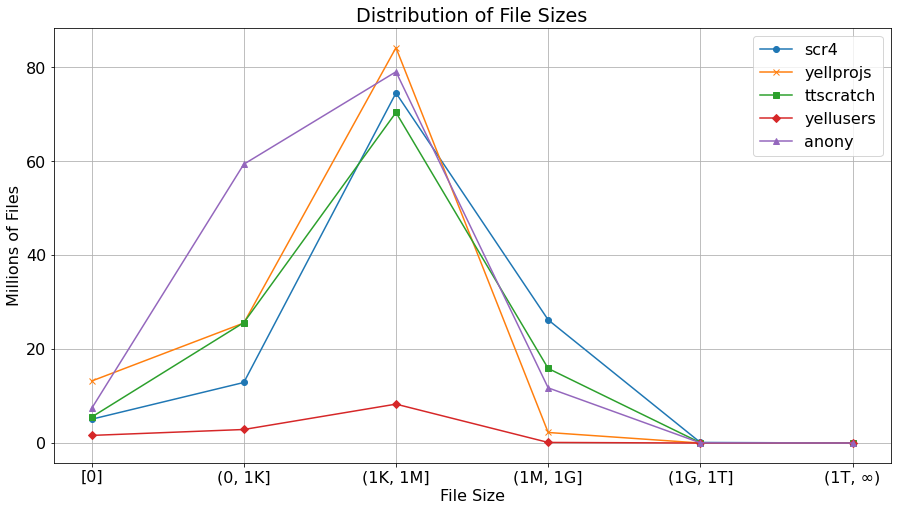

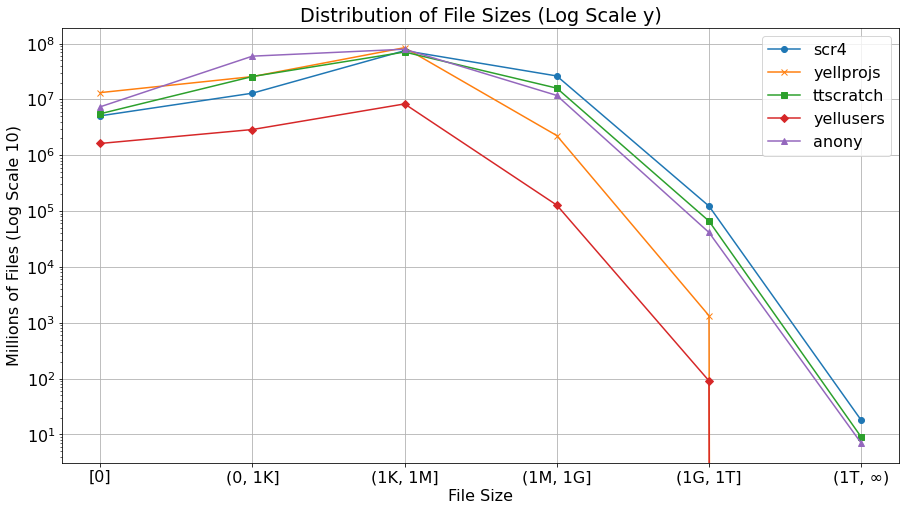

In [113]:
def frames_to_plt(dataframes,logscale=False):
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 16


    # Plot the data as a line graph
    markers = ['o', 'x', 's', 'D', '^', 'v']
    for idx, (indexroot, df) in enumerate(dataframes.items()):
        shortname = indexroot.rstrip('/').split("/")[-1]
        plt.plot(df['Upper_Bound'], df['Num_Files'], marker=markers[idx], label=shortname)

    # y-tics are ugly, change them to be in values of millions
    def millions(x, pos):
        return f'{int(x/1e6)}'
    ax = plt.gca()
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)

    # Add labels and title
    plt.xlabel('File Size')
    plt.ylabel('Millions of Files')
    plt.title('Distribution of File Sizes')

    # avoid transparent background
    for item in (ax.figure, ax):
        item.set_facecolor('white')

    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    if logscale:
        # then add logscale and show it again
        ax.set_yscale('log')
        ax.set_title(ax.get_title() + " (Log Scale y)")
        ax.set_ylabel(ax.get_ylabel() + " (Log Scale 10)")
        
    return plt

plt = frames_to_plt(dataframes)
plt.show()
plt2 = frames_to_plt(dataframes,logscale=True)
plt2.show()